# Gravity disturbance produced by a prism

This code illustrates how to compute the gravity disturbance produced by a homogeneous rectangular prism. We presume that the gravity disturbance can be approximated by the vertical component of the gravitational attraction produced by the prism.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import rectangular_prism_fields as rpf
from gravmag import plot_functions as plf

### Model

In [2]:
# Create a model formed by a single prism
model = np.array([[-500, 500, 0, 2000, 10, 1010]])

density = np.array([2000]) # 2000 kg/m³ = 2 g/cm³

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)

yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

### Synthetic gravity disturbance (in mGal)

In [4]:
# Compute the vertical component of acceleration
gz = rpf.grav(coordinates=coordinates, 
              prisms=model, 
              density=density, 
              field='g_z')

### Plot the computed gravity disturbance

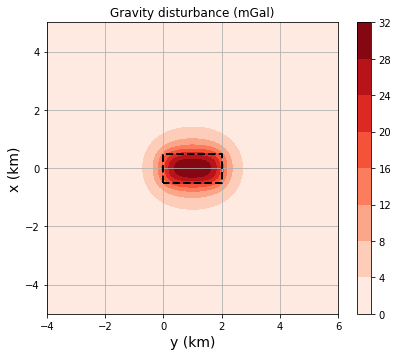

In [5]:
plt.figure(figsize=(6,5))

plt.title("Gravity disturbance (mGal)")
plt.axis('scaled')
plt.contourf(yp.reshape(shape)*0.001, 
             xp.reshape(shape)*0.001, 
             gz.reshape(shape), cmap='Reds')
plt.colorbar()
plf.model_boundaries(model)
plt.ylim(0.001*area[0], 0.001*area[1])
plt.xlim(0.001*area[2], 0.001*area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()
plt.tight_layout()

plt.show()